In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pyod.models.auto_encoder import AutoEncoder
from keras.models import Sequential
from keras.layers import Dense
from ann_visualizer.visualize import ann_viz


In [11]:
cleanDf = pd.read_excel('ViewData.xlsx')
cleanDf.info()
cleanDf.dropna(inplace=True)
cleanDf['date_time'] = pd.to_datetime(cleanDf['date_time'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3048 entries, 0 to 3047
Data columns (total 7 columns):
Unnamed: 0                   3048 non-null int64
date_time                    3048 non-null object
price_usd                    3048 non-null float64
srch_booking_window          3048 non-null int64
srch_saturday_night_bool     3048 non-null int64
srch_booking_window.1        3048 non-null int64
orig_destination_distance    3048 non-null float64
dtypes: float64(2), int64(4), object(1)
memory usage: 166.8+ KB


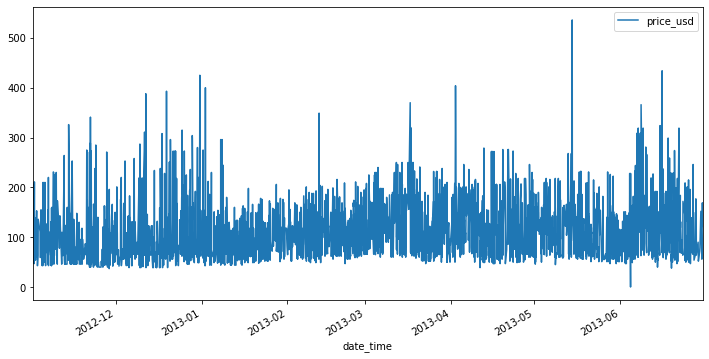

In [12]:
cleanDf.plot(x='date_time', y='price_usd', figsize=(12,6))
plt.show()


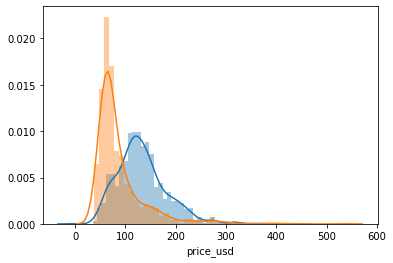

In [14]:
sat = cleanDf.loc[cleanDf['srch_saturday_night_bool'] == 1,'price_usd']
nonSat = cleanDf.loc[cleanDf['srch_saturday_night_bool'] == 0,'price_usd']
sns.distplot(sat,bins=50)
sns.distplot(nonSat,bins=50)
plt.show()


The Distribution of the data for the saturday vs non saturday prices

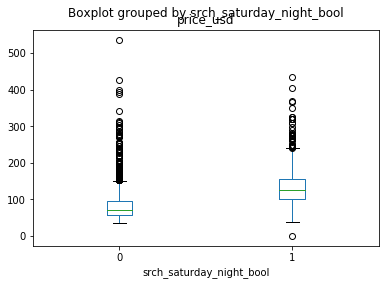

In [68]:
cleanDf.boxplot(by ='srch_saturday_night_bool', column =['price_usd'], grid = False)

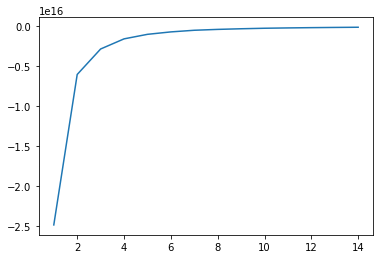

In [15]:
dropClean = cleanDf.drop(['date_time'],axis=1)
score = []
for i in range(1,15):
    kFit = KMeans(n_clusters=i).fit(dropClean)
    score.append(kFit.score(dropClean))
sns.lineplot(range(1,15),score)
plt.show()


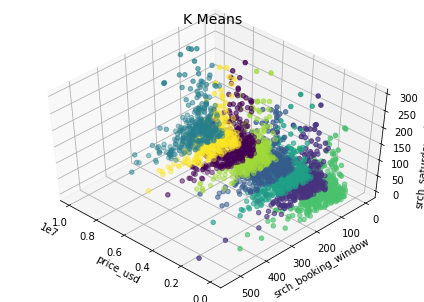

In [16]:
kFit = KMeans(n_clusters=8).fit(dropClean)
kFit.predict(dropClean)
label = kFit.labels_

fig = plt.figure()
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(dropClean.iloc[:,0], dropClean.iloc[:,1], dropClean.iloc[:,2],
          c=label)
ax.set_xlabel("price_usd")
ax.set_ylabel("srch_booking_window")
ax.set_zlabel("srch_saturday_night_bool")
plt.title("K Means", fontsize=14)
plt.show()


KNN cant reduce the dimentionality of the data and totally depends on the distance and similarity between the data observations
clustering algos have an issue with having to fit with the observation distribution too many models ( birch, spactial, spectral etc.) 


Covariance matrix 
[[ 1.00032819  0.03350386  0.04604068  0.03704769  0.04604068  0.02080146
   0.04819651]
 [ 0.03350386  1.00032819 -0.06464936  0.41098219 -0.06464936 -0.0525525
   0.19053163]
 [ 0.04604068 -0.06464936  1.00032819  0.02234168  1.00032819  0.21720319
   0.27507758]
 [ 0.03704769  0.41098219  0.02234168  1.00032819  0.02234168 -0.10220004
   0.01505688]
 [ 0.04604068 -0.06464936  1.00032819  0.02234168  1.00032819  0.21720319
   0.27507758]
 [ 0.02080146 -0.0525525   0.21720319 -0.10220004  0.21720319  1.00032819
   0.01002521]
 [ 0.04819651  0.19053163  0.27507758  0.01505688  0.27507758  0.01002521
   1.00032819]]
Eigenvectors 
[[-6.44519668e-02 -1.11587021e-01 -1.95110609e-02  9.80132075e-01
   1.18856746e-01 -9.07071613e-02 -6.66008543e-20]
 [ 3.21503688e-02 -6.80259535e-01 -6.62707036e-01 -4.17555109e-02
  -2.65516250e-01  1.57449362e-01 -1.41399051e-16]
 [-6.52119810e-01  1.30305264e-02 -1.32010813e-01 -7.17405247e-02
   2.28026214e-01 -6.69162600e-04 -7.0710678

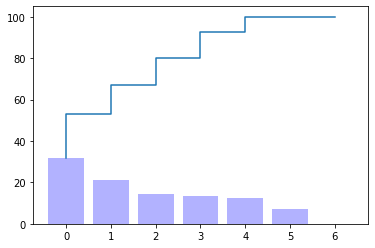

C:\Python37\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


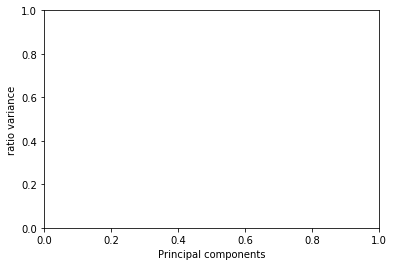

In [19]:
dropClean_std = StandardScaler().fit_transform(dropClean)
mean_vec = np.mean(dropClean_std, axis=0)
##Covarinace Matrix
cov_mat = (dropClean_std - mean_vec).T.dot((dropClean_std - mean_vec)) / (dropClean_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)
##Eigen Values of Covariance Matrix
eigVals, eigVecs = np.linalg.eig(cov_mat)
print('Eigenvectors \n%s' %eigVecs )
print('\nEigenvalues \n%s' %eigVals)

eigens = {}
for i in range(len(eigVals)):
    eigens[eigVals[i]] = eigVecs[:,i]

##### Plot the PCA #####

total = sum(eigVals)
variance = [(i / total)*100 for i in sorted(eigVals, reverse=True)]
cummuVar = np.cumsum(variance)
plt.bar(range(len(variance)), variance, alpha=0.3, align='center', color = 'b')
plt.step(range(len(cummuVar)), cummuVar)
plt.show()
plt.ylabel('ratio variance')
plt.xlabel('Principal components')
#

pca = PCA(n_components=4)
dropCleanPCA = pca.fit_transform(dropClean)
# standardize these 2 new features
scaler = StandardScaler()
np_scaled = scaler.fit_transform(dropCleanPCA)
dataFinal = pd.DataFrame(np_scaled)

allDistance = pd.Series()
newK = KMeans(n_clusters=8).fit(dataFinal)

for i in range(len(dataFinal)):
    a = np.array(dataFinal.loc[i])
    # getting the clusters for the selected data row
    b = newK.cluster_centers_[newK.labels_[i]-1]
    ##the euclidian distance
    allDistance.set_value(i, np.linalg.norm(a - b))

#assumption of outlier percentage
threshfrac = 0.01
number_of_outliers = int(threshfrac*len(allDistance))
thresh = allDistance.nlargest(number_of_outliers).min()
dropClean['anomaly1'] = (allDistance >= thresh).astype(int)
dropClean.to_excel('CalculatdAnomaly.xlsx')

In [31]:
nnData = pd.read_excel("nnViewData.xlsx")
nnData = nnData.drop(['date_time'],axis=1)
dropCleanScale = StandardScaler().fit_transform(nnData)
dropCleanScale = pd.DataFrame(dropCleanScale)

nnDataTest = pd.read_excel("nnViewDataTest.xlsx")
nnDataTest = nnDataTest.drop(['date_time'],axis=1)
dropCleanScaleTest = StandardScaler().fit_transform(nnDataTest)
dropCleanScaleTest = pd.DataFrame(dropCleanScaleTest)


In [32]:
clf1 = AutoEncoder(hidden_neurons =[14, 4, 14])
clf1.fit(dropCleanScale)
y_train_scores1 = clf1.decision_scores_

clf2 = AutoEncoder(hidden_neurons =[14, 8, 4, 8, 14])
clf2.fit(dropCleanScale)
y_train_scores2 = clf2.decision_scores_

y_test1 = clf1.decision_function(dropCleanScaleTest)
y_test2 = clf2.decision_function(dropCleanScaleTest)


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 15)                240       
_________________________________________________________________
dropout_39 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 15)                240       
_________________________________________________________________
dropout_40 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 14)                224       
_________________________________________________________________
dropout_41 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 4)                

2475/2475 [==============================] - 0s 40us/step - loss: 1.1100 - val_loss: 1.0477
Epoch 62/100
2475/2475 [==============================] - 0s 38us/step - loss: 1.0987 - val_loss: 1.0383
Epoch 63/100
2475/2475 [==============================] - 0s 39us/step - loss: 1.0883 - val_loss: 1.0283
Epoch 64/100
2475/2475 [==============================] - 0s 39us/step - loss: 1.0754 - val_loss: 1.0191
Epoch 65/100
2475/2475 [==============================] - 0s 41us/step - loss: 1.0670 - val_loss: 1.0102
Epoch 66/100
2475/2475 [==============================] - 0s 41us/step - loss: 1.0577 - val_loss: 1.0015
Epoch 67/100
2475/2475 [==============================] - 0s 39us/step - loss: 1.0478 - val_loss: 0.9934
Epoch 68/100
2475/2475 [==============================] - 0s 39us/step - loss: 1.0381 - val_loss: 0.9854
Epoch 69/100
2475/2475 [==============================] - 0s 41us/step - loss: 1.0293 - val_loss: 0.9773
Epoch 70/100
2475/2475 [==============================] - 0s 40us/st

2475/2475 [==============================] - 0s 47us/step - loss: 2.6960 - val_loss: 2.4481
Epoch 17/100
2475/2475 [==============================] - 0s 46us/step - loss: 2.5892 - val_loss: 2.3504
Epoch 18/100
2475/2475 [==============================] - 0s 46us/step - loss: 2.4829 - val_loss: 2.2633
Epoch 19/100
2475/2475 [==============================] - 0s 46us/step - loss: 2.3832 - val_loss: 2.1843
Epoch 20/100
2475/2475 [==============================] - 0s 47us/step - loss: 2.3276 - val_loss: 2.1121
Epoch 21/100
2475/2475 [==============================] - 0s 45us/step - loss: 2.2516 - val_loss: 2.0446
Epoch 22/100
2475/2475 [==============================] - 0s 44us/step - loss: 2.1757 - val_loss: 1.9835
Epoch 23/100
2475/2475 [==============================] - 0s 49us/step - loss: 2.1128 - val_loss: 1.9265
Epoch 24/100
2475/2475 [==============================] - 0s 50us/step - loss: 2.0599 - val_loss: 1.8735
Epoch 25/100
2475/2475 [==============================] - 0s 47us/st

2475/2475 [==============================] - 0s 47us/step - loss: 0.8896 - val_loss: 0.8274
Epoch 95/100
2475/2475 [==============================] - 0s 45us/step - loss: 0.8863 - val_loss: 0.8241
Epoch 96/100
2475/2475 [==============================] - 0s 46us/step - loss: 0.8826 - val_loss: 0.8210
Epoch 97/100
2475/2475 [==============================] - 0s 46us/step - loss: 0.8798 - val_loss: 0.8180
Epoch 98/100
2475/2475 [==============================] - 0s 47us/step - loss: 0.8763 - val_loss: 0.8151
Epoch 99/100
2475/2475 [==============================] - 0s 46us/step - loss: 0.8733 - val_loss: 0.8124
Epoch 100/100
2475/2475 [==============================] - 0s 47us/step - loss: 0.8711 - val_loss: 0.8097


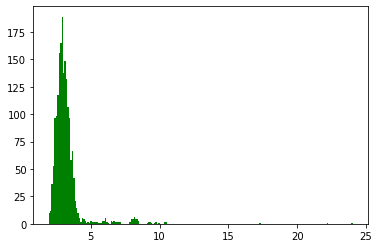

In [29]:
plt.hist(y_test1, bins='auto',color='green')
plt.show()


The anomaly score 5 seems to be the cut point and those >=5.0 to be outliers.

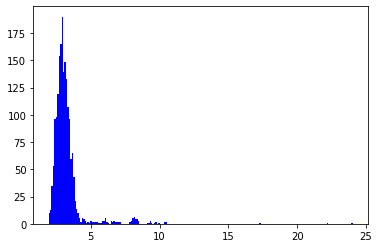

In [30]:
plt.hist(y_test2, bins='auto',color='blue')
plt.show()

The anomaly score 5 seems to be consistent for the 14, 8, 4, 8, 14 structured neural network the cut point and those >=5.0 to be outliers.